# Cohort Analysis in Python

Excellent content created by Greg Reda @
http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/

A cohort is a group of users who share something in common, be it their sign-up date, first purchase month, birth date, acquisition channel, etc. Cohort analysis is the method by which these groups are tracked over time, helping you spot trends, understand repeat behaviors (purchases, engagement, amount spent, etc.), and monitor your customer and revenue retention.

It’s common for cohorts to be created based on a customer’s first usage of the platform, where "usage" is dependent on your business’ key metrics. For Uber or Lyft, usage would be booking a trip through one of their apps. For GrubHub, it’s ordering some food. For AirBnB, it’s booking a stay.

With these companies, a purchase is at their core, be it taking a trip or ordering dinner — their revenues are tied to their users’ purchase behavior.

In others, a purchase is not central to the business model and the business is more interested in "engagement" with the platform. Facebook and Twitter are examples of this - are you visiting their sites every day? Are you performing some action on them - maybe a "like" on Facebook or a "favorite" on a tweet?1

When building a cohort analysis, it’s important to consider the relationship between the event or interaction you’re tracking and its relationship to your business model.

Cohort analysis can be helpful when it comes to understanding your business’ health and "stickiness" - the loyalty of your customers. Stickiness is critical since it’s far cheaper and easier to keep a current customer than to acquire a new one. For startups, it’s also a key indicator of product-market fit.

Additionally, your product evolves over time. New features are added and removed, the design changes, etc. Observing individual groups over time is a starting point to understanding how these changes affect user behavior.

It’s also a good way to visualize your user retention/churn as well as formulating a basic understanding of their lifetime value.


**Import Libraries**
In this example we will be using three common libraries:
1. `pandas` for data management
2. `numpy` for numeric computation
3. `matplotlib` and `seaborne` for visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

C:\Users\bharder\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


**Read in the data and check it out**
The data is read in using the standard `pandas read_csv` function with no additional arguments.

In [2]:
df = pd.read_csv(r'C:\Users\foo\cohortdemo.csv') #read in data
df.info() #info on the dataframe, similar to str in R

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 7 columns):
OrderId         2891 non-null int64
OrderDate       2891 non-null object
UserId          2891 non-null int64
TotalCharges    2891 non-null float64
CommonId        2891 non-null object
PupId           2891 non-null int64
PickupDate      2891 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 124.3+ KB


In [3]:
df.head() #checkout the head of the data

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,1/11/2009,47,50.67,TRQKD,2,1/12/2009
1,278,1/20/2009,47,26.60,4HH2S,3,1/20/2009
2,294,2/3/2009,47,38.71,3TRDC,2,2/4/2009
3,301,2/6/2009,47,53.38,NGAZJ,2,2/9/2009
4,302,2/6/2009,47,14.28,FFYHD,2,2/9/2009


**Clean data and drop uneccessary columns**

I use pandas `to_datetime` to automagically turn the order data into a data type.  Then drop the remaining columns as they do not provide any value in this context.  

In [4]:
df['OrderDate'] = pd.to_datetime(df['OrderDate']) #change to datatime
df = df.drop(df.columns[[4, 5, 6]], axis=1) #drop uneeded columns
df.head() #check it out

,OrderId,OrderDate,UserId,TotalCharges
0,262,2009-01-11,47,50.67
1,278,2009-01-20,47,26.60
2,294,2009-02-03,47,38.71
3,301,2009-02-06,47,53.38
4,302,2009-02-06,47,14.28


**Create period column based on the OrderDate**

Create a new column that rolls up the cohort by month.  

In [5]:
df['OrderPeriod'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m')) #order by period, truncate datetime to year-month
df.head() #check it out

,OrderId,OrderDate,UserId,TotalCharges,OrderPeriod
0,262,2009-01-11,47,50.67,2009-01
1,278,2009-01-20,47,26.60,2009-01
2,294,2009-02-03,47,38.71,2009-02
3,301,2009-02-06,47,53.38,2009-02
4,302,2009-02-06,47,14.28,2009-02


**Determine the user's cohort group (based on their first order)**

In [6]:
df.set_index('UserId', inplace=True) #set index based on user ID

df['CohortGroup'] = df.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m')) #order by first date
df.reset_index(inplace=True) #reset index
df.head() #check out the data frame

,UserId,OrderId,OrderDate,TotalCharges,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,2009-01,2009-01
1,47,278,2009-01-20,26.60,2009-01,2009-01
2,47,294,2009-02-03,38.71,2009-02,2009-01
3,47,301,2009-02-06,53.38,2009-02,2009-01
4,47,302,2009-02-06,14.28,2009-02,2009-01


**Rollup data by CohortGroup & OrderPeriod**

Since we're looking at monthly cohorts, we need to aggregate users, orders, and amount spent by the CohortGroup within the month (OrderPeriod).

In [7]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod']) #group by cohort group and order period

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'UserId': pd.Series.nunique,
                       'OrderId': pd.Series.nunique,
                       'TotalCharges': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'UserId': 'TotalUsers',
                        'OrderId': 'TotalOrders'}, inplace=True)
cohorts.head() #check it out

TotalOrders  TotalUsers  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01               30          22       1850.26
            2009-02               25           8       1351.07
            2009-03               26          10       1357.36
            2009-04               28           9       1604.50
            2009-05               26          10       1575.63

**Label the CohortPeriod for each CohortGroup**

We want to look at how each cohort has behaved in the months following their first purchase, so we'll need to index each cohort to their first purchase month. For example, CohortPeriod = 1 will be the cohort's first month, CohortPeriod = 2 is their second, and so on.

This allows us to compare cohorts across various stages of their lifetime.

In [8]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period) 
cohorts.head()

TotalOrders  TotalUsers  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01               30          22       1850.26             1
            2009-02               25           8       1351.07             2
            2009-03               26          10       1357.36             3
            2009-04               28           9       1604.50             4
            2009-05               26          10       1575.63             5

**Make sure we did all that right**

In [9]:
x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-01')]
y = cohorts.ix[('2009-01', '2009-01')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum() == y['TotalCharges'])
assert(x['OrderId'].nunique() == y['TotalOrders'])

x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-09')]
y = cohorts.ix[('2009-01', '2009-09')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum() == y['TotalCharges'])
assert(x['OrderId'].nunique() == y['TotalOrders'])

x = df[(df.CohortGroup == '2009-05') & (df.OrderPeriod == '2009-09')]
y = cohorts.ix[('2009-05', '2009-09')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum() == y['TotalCharges'])
assert(x['OrderId'].nunique() == y['TotalOrders'])

**User Retention by Cohort Group**

We want to look at the percentage change of each CohortGroup over time -- not the absolute change.  To do this, we'll first need to create a pandas Series containing each CohortGroup and its size.

In [10]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

Now, we'll need to divide the `TotalUsers` values in `cohorts` by `cohort_group_size`. Since DataFrame operations are performed based on the indices of the objects, we'll use `unstack` on our `cohorts` DataFrame to create a matrix where each column represents a CohortGroup and each row is the CohortPeriod corresponding to that group.

To illustrate what `unstack` does, recall the first five `TotalUsers` values:

In [11]:
cohorts['TotalUsers'].head() 

CohortGroup  CohortPeriod
2009-01      1               22
             2                8
             3               10
             4                9
             5               10
Name: TotalUsers, dtype: int64

In [12]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,22.0,15.0,13.0,39.0,50.0,32.0,50.0,31.0,37.0,54.0,130.0,65.0,95.0,100.0,24.0
2,8.0,3.0,4.0,13.0,13.0,15.0,23.0,11.0,15.0,17.0,32.0,17.0,50.0,19.0,NaN
3,10.0,5.0,5.0,10.0,12.0,9.0,13.0,9.0,14.0,12.0,26.0,18.0,26.0,NaN,NaN
4,9.0,1.0,4.0,13.0,5.0,6.0,10.0,7.0,8.0,13.0,29.0,7.0,NaN,NaN,NaN
5,10.0,4.0,1.0,6.0,4.0,7.0,11.0,6.0,13.0,13.0,13.0,NaN,NaN,NaN,NaN


Finally, we can plot the cohorts over time in an effort to spot behavioral differences or similarities. Two common cohort charts are line graphs and heatmaps, both of which are shown below.

Notice that the first period of each cohort is 100% -- this is because our cohorts are based on each user's first purchase, meaning everyone in the cohort purchased in month 1.

In [13]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,0.15625,0.20,0.258065,0.243243,0.129630,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,0.09375,0.22,0.129032,0.216216,NaN,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,0.09375,0.14,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,0.31250,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Visualize the results**

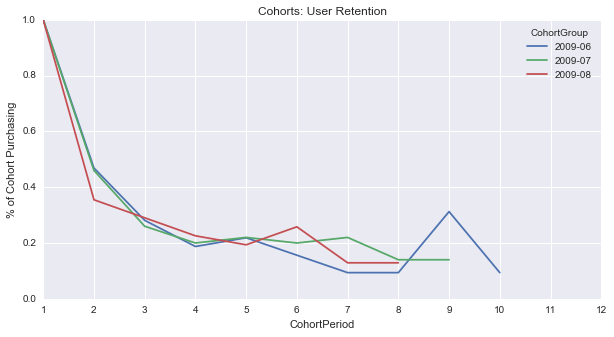

In [14]:
user_retention[['2009-06', '2009-07', '2009-08']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

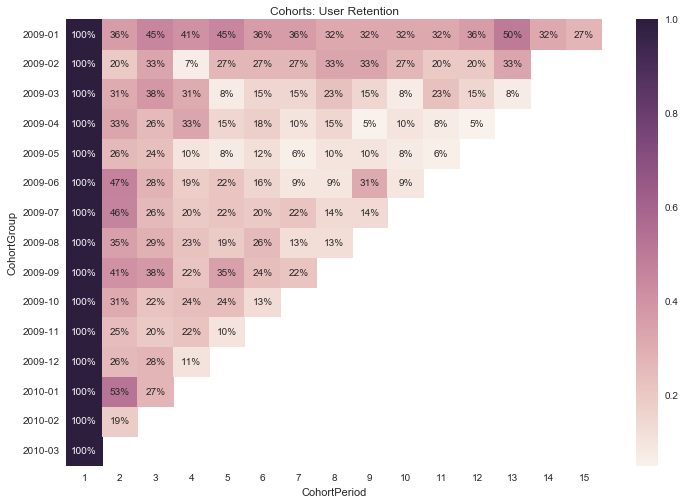

In [15]:
# Creating heatmaps in matplotlib is more difficult than it should be.
# Thankfully, Seaborn makes them easy for us.
# http://stanford.edu/~mwaskom/software/seaborn/


sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

**bonus - try it with bokeh**

In [ ]:
from bokeh.plotting import figure, show, output_file, vplot
p1 = figure()
p1.title = "Cohorts: User Retention"
p1.grid.grid_line_alpha=0.3
p1.xaxis.axis_label = 'Cohort Period'
p1.yaxis.axis_label = '% of Cohort Purchasing'

p1.line(range(1,16), user_retention['2009-06'], color='#A6CEE3', legend='2009-06')
p1.line(range(1,16), user_retention['2009-07'], color='#B2DF8A', legend='2009-07')
p1.line(range(1,16), user_retention['2009-08'], color='#33A02C', legend='2009-08')
p1.line(range(1,16), user_retention['2009-09'], color='#FB9A99', legend='2009-09')

output_file("cohorts.html", title="cohorts.py example")
show(p1)  # open a browser